## Import libraries 

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Prepare the dataset

### Upload dataset by  mounting Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Or upload by url

In [3]:
import urllib
import urllib.request

dataset_url = 'https://drive.google.com/file/d/1nfKlVaKudLl1gyqGfPFHc2H2DnBsM_bc/view?usp=sharing'
dataset_file_name = 'data_surnamesIJKLM.zip'

label_url = 'https://drive.google.com/file/d/12mMi5WiOZ8pMbNVQW8hYvnkmtas-KL5c/view?usp=sharing'
label_file_name = 'filename_to_category_map_surnamesIJKLM.csv'

urllib.request.urlretrieve(dataset_url, dataset_file_name)
urllib.request.urlretrieve(label_url, label_file_name)

print('Label Download completed!')
print('Dataset Download completed!')

Label Download completed!
Dataset Download completed!


### Unzip the dataset

In [ ]:
!unzip '/content/drive/MyDrive/COMP-1804 Coursework sub-task 3/Dataset/data_surnamesIJKLM.zip'

In [9]:
# Set the path of the dataset
dataset_dir = ('/content/data_surnamesIJKLM/')
os.listdir(dataset_dir)

['2']

### Load the labels of dataset into dataframe

In [10]:
# Load the labels of dataset into dataframe
data_labels = pd.read_csv("/content/drive/MyDrive/COMP-1804 Coursework sub-task 3/Dataset/filename_to_category_map_surnamesIJKLM.csv",sep=',', engine ='python', encoding='utf-8')

# add other column with just the image file name
# the function below splits the subfolde/img_filename path on the forward slash

data_labels['filename']= data_labels['img_filename'].apply(lambda x: x.split('/')[1])
data_labels['img_filename'] = data_labels['img_filename'].map(lambda x: dataset_dir + x)
data_labels.head()

,img_filename,category,filename
0,/content/data_surnamesIJKLM/2/100012.jpg,other_service,100012.jpg
1,/content/data_surnamesIJKLM/2/100022.jpg,soda,100022.jpg
2,/content/data_surnamesIJKLM/2/100042.jpg,soda,100042.jpg
3,/content/data_surnamesIJKLM/2/100062.jpg,clothing,100062.jpg
4,/content/data_surnamesIJKLM/2/100082.jpg,unclear,100082.jpg


In [11]:
# assign the directory where the data is stored to a different variable
# this is just for compatibility with the cells below
import pathlib
try:
    data_dir= dataset_dir
except:
    print('Please run ALL of the cells above first, then rerun this cell, then continue')
    raise ValueError('Please run ALL of the cells above first, then rerun this cell, then continue')

#this transforms our directory string into a Path object, which is more powerful than a simple string for filenames
data_dir = pathlib.Path(data_dir) 

## EDA & Data Cleaning

### Description of data

How many images are in the dataset?
How many labels do we have?

In [12]:
# Explore the data
image_count = len(list(data_dir.glob('*/*.jpg')))
print('We have ' + str(image_count) + ' images in the dataset')

n_labels = data_labels['category'].nunique()
print('We have ' + str(n_labels) + ' of different labels' )

print('Duplicate values :' , len(data_labels[data_labels.duplicated()]))
print('Missing values :', data_labels.isnull().sum().sum())

We have 5984 images in the dataset
We have 39 of different labels
Duplicate values : 0
Missing values : 111


### Add height and width to the image labels dataframe

In [13]:
import cv2
all_image_files = []
image_sizes = []
for subdir in list(data_dir.glob('*')):
    for img_file in list(subdir.glob('*')):
      all_image_files.append(img_file)
      img = cv2.imread(os.path.join(subdir, img_file))
      #img = PIL.Image.open(img_file)
      image_sizes.append(img.shape) #this stores width and height, not number of channels

data_labels['width']= [t[1] for t in image_sizes]
data_labels['height']= [t[0] for t in image_sizes]


In [14]:
# Finally, let's store the typical image size
from scipy import stats
img_shape = tuple(stats.mode(image_sizes)[0][0]) + (3,)
nb_of_pixels = img_shape[0]*img_shape[1]*img_shape[2]
print('Typical image size: ',img_shape)
print('Total number of pixels: ', nb_of_pixels)

Typical image size:  (400, 600, 3, 3)
Total number of pixels:  720000


In [15]:
# Create dataframe for exclusion dataset
exclusion_dataset = data_labels.copy()

### Data Cleaning
-Remove the missing values

In [16]:
# filter out images that with height smaller than 200 pixels
data_labels = data_labels[data_labels.height > 200]

# Remove missing values
data_labels = data_labels.dropna()

### Label distributions per attribute

In [17]:
labels_count=pd.DataFrame(data_labels['category'].value_counts().sort_index())
#labels_count = labels_count.reset_index()
labels_count = labels_count.rename(columns={"index": "category", "category": "count"})
labels_count= labels_count.sort_values('count',ascending=False)
print(labels_count)

                             count
clothing                       809
cars                           662
beauty                         519
electronics                    381
soda                           362
restaurant                     301
alcohol                        277
sports                         266
chocolate                      265
travel                         207
chips                          161
media                          153
shopping                       151
financial                      128
unclear                        123
other_service                  110
healthcare                      87
seasoning                       86
phone_tv_internet_providers     83
game                            68
smoking_alcohol_abuse           68
safety                          64
coffee                          64
home_appliance                  62
animal_right                    46
software                        41
environment                     32
human_right         

## Grouping Labels

In [18]:
# Grouping the label and print out the distribute of new labels
def group_categories(x):
    if x in ['soda', 'coffee', 'alcohol', 'chocolate', 'chips', 'petfood', 'seasoning', 'baby', 'cleaning']:
        return ('grocery')
    
    elif x in ["game", "gambling","security"]:
        return ("entertainment")
    
    elif x in ["home_appliance" ,"home_improvement"]:
        return ('home')
    
    elif x in ["animal_right","self_esteem","political","domestic_violence","human_right","smoking_alcohol_abuse","environment"]:
        return ('social_issues')
    
    elif x in ["healthcare", "other_service", "phone_tv_internet_providers"]:
        return ("services")
    
    elif x in ["electronics", "software"]:
        return ("technology")
    
    else:
        return x

data_labels['category'] = data_labels['category'].map(lambda x:group_categories(x))

new_labels_count=pd.DataFrame(data_labels['category'].value_counts().sort_index())
#labels_count = labels_count.reset_index()
new_labels_count = new_labels_count.rename(columns={"index": "category", "category": "count"})
new_labels_count= new_labels_count.sort_values('count',ascending=False)
print(new_labels_count)

               count
grocery         1256
clothing         809
cars             662
beauty           519
technology       422
restaurant       301
services         280
sports           266
social_issues    231
travel           207
media            153
shopping         151
financial        128
unclear          123
home              89
entertainment     83
safety            64
education         14
charities          8


### What is the size of the images?

Text(0, 0.5, 'Counts')

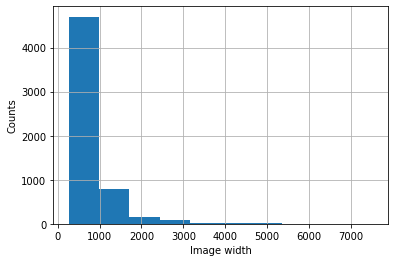

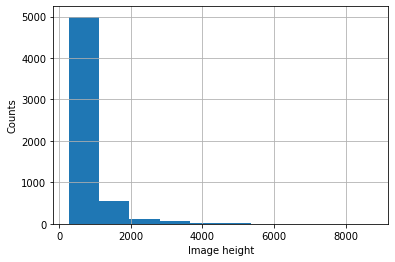

In [19]:
#let's check the widths and heights
plt.figure()
data_labels['width'].hist()
#plt.hist([t[0] for t in all_image_sizes])
plt.xlabel('Image width')
plt.ylabel('Counts')

plt.figure()
data_labels['height'].hist()
#plt.hist([t[1] for t in all_image_sizes])
plt.xlabel('Image height')
plt.ylabel('Counts')


In [20]:
# Check how many labels exist in the dataset
n_labels = data_labels['category'].nunique()
print('We have ' + str(n_labels) + ' of different labels' )

We have 19 of different labels


### Drop out category 'unclear' and filter out category that has images less than 10

In [21]:
# Drop unwanted category (unclear & category that the images less than 10 )
data_filtered = data_labels.loc[data_labels['category'] != 'unclear']
data_filtered = data_filtered[data_filtered.category.map(data_filtered.category.value_counts() > 10)]

Now check again the dataset

In [22]:
# Updated description of data
updated_image_count = len(data_filtered)
print(f'Updated number of images: {updated_image_count}')

updated_labels = data_filtered['category'].nunique()
print(f'Updated number of labels: {updated_labels} ' )
print('Duplicate values :' , len(data_filtered[data_filtered.duplicated()]))
print('Missing values :', data_filtered.isnull().sum().sum())


Updated number of images: 5635
Updated number of labels: 17 
Duplicate values : 0
Missing values : 0


### Make exclusion dataset

In [23]:
exclusion_dataset['data_id'] = exclusion_dataset['filename']
exclusion_dataset['excluded'] =np.nan
exclusion_dataset['reason_for_exclusion'] =np.nan

# Replace NaN with 0 in 'excluded' column to avoid unnecessary removal
exclusion_dataset['excluded'] = exclusion_dataset['excluded'].fillna(0)
# Replace NaN with 'N/A' in 'reason_for_exclusion' column to avoid unnecessary removal
exclusion_dataset['reason_for_exclusion'] = exclusion_dataset['reason_for_exclusion'].fillna('N/A')


# Mark the excluded images in the exclusion dataset
exclusion_dataset.loc[exclusion_dataset['height']<200, 'excluded'] = 1 
# Mark the reason of exlusion as 'disrupted' (Image size too small)
exclusion_dataset.loc[exclusion_dataset['height']<200, 'reason_for_exclusion'] = 'invalid'


# Missing value
exclusion_dataset.loc[exclusion_dataset.isnull().any(axis=1), 'excluded'] = 1
exclusion_dataset.loc[exclusion_dataset.isnull().any(axis=1), 'reason_for_exclusion'] = 'missing_value_or_label'

# Exclude 'unclear' label
exclusion_dataset.loc[exclusion_dataset['category'] == 'unclear', 'excluded'] = 1
exclusion_dataset.loc[exclusion_dataset['category'] == 'unclear', 'reason_for_exclusion'] = 'invalid'

# Change the data type of 'excluded' column from float to int
exclusion_dataset = exclusion_dataset.astype({'excluded':'int'})

# Drop unnecessary column
exclusion_dataset= exclusion_dataset.drop(exclusion_dataset.columns[[0, 1, 2, 3, 4]], axis=1) 

# Save the exclusion dataset to csv

exclusion_dataset.to_csv('exclusions_dataset_task3.csv',index=False)

## Visualise Data

###Display some sample image in the dataset

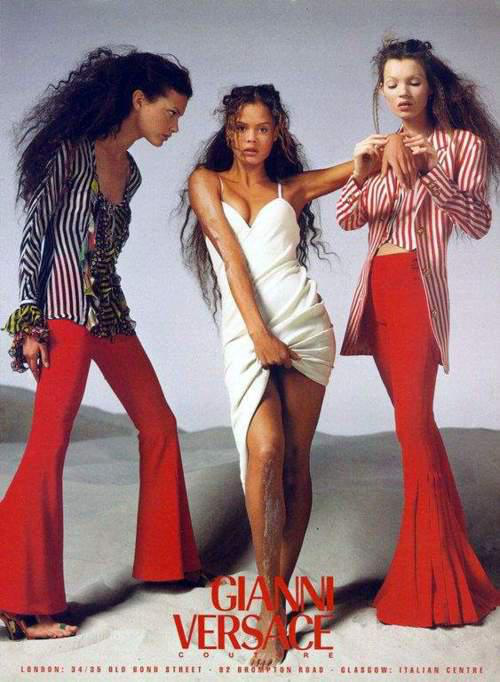

In [85]:
sample_fp = data_filtered.sample(123).img_filename.values[0]
PIL.Image.open(sample_fp)

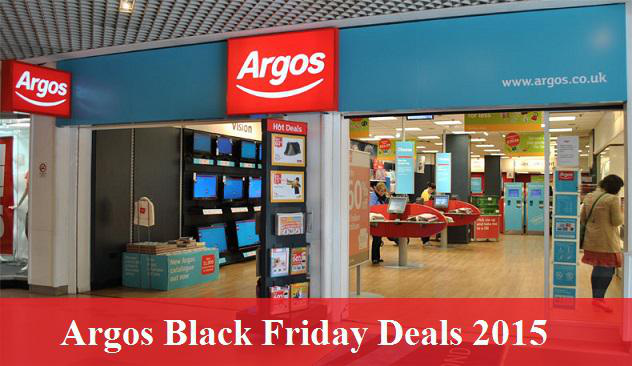

In [25]:
sample_fp2 = data_filtered.sample(2).img_filename.values[1]
PIL.Image.open(sample_fp2)

### One-hot encoding


In [26]:
#One-hot encoding using LabelBinarizer
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

data_filtered_enc = data_filtered.join(pd.DataFrame(encoder.fit_transform(data_filtered['category']),
                          columns=encoder.classes_, 
                          index=data_filtered.index))
n_classes = len(encoder.classes_)
class_index = {i:c for i,c in enumerate(encoder.classes_)}

In [27]:
class_index

{0: 'beauty',
 1: 'cars',
 2: 'clothing',
 3: 'education',
 4: 'entertainment',
 5: 'financial',
 6: 'grocery',
 7: 'home',
 8: 'media',
 9: 'restaurant',
 10: 'safety',
 11: 'services',
 12: 'shopping',
 13: 'social_issues',
 14: 'sports',
 15: 'technology',
 16: 'travel'}

### Data Splitting

In [28]:
from sklearn.model_selection import train_test_split
train_valid_df, test_df = train_test_split(data_filtered_enc, test_size=0.2, random_state=123, shuffle=True, stratify=data_filtered_enc.category)
train_df, valid_df = train_test_split(train_valid_df, test_size=0.2, random_state=152, shuffle=True, stratify=train_valid_df.category)

In [29]:
#Upsampling
def upsample_df(df):
  df_list=[]
  n_upsample = max(df.category.value_counts())

  for label in df.category.unique():
    upsampled_category = df[df['category'] == label].sample(n=n_upsample,replace=True,random_state=123, axis=0)
    df_list.append(upsampled_category)

  df_upsampled = pd.concat(df_list,axis=0).reset_index(drop=True)
  return df_upsampled

In [30]:
train_df = upsample_df(train_df)
valid_df = upsample_df(valid_df)
test_df = upsample_df(test_df)

In [70]:
def read_img_resize(img_fp,label):
  img_bytes = tf.io.read_file(img_fp)
  img_arr = tf.image.decode_jpeg(img_bytes,channels = 3)
  img = tf.image.resize_with_pad(img_arr, 256,256)
  return img, tf.cast(label, tf.float32)

def img_aug(image,label):
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, 0.2)
  image = tf.image.random_contrast(image, 0.5, 2.0)
  image = tf.image.random_saturation(image, 0.75, 1.25)
  image = tf.image.random_hue(image, 0.1)
  return image, label

### Define batch size

In [32]:
batch_size = 64 #this defines how many images we want to load at any one time during training
img_height = 256
img_width = 256
image_aug = True

In [71]:
# make datasets
AUTOTUNE = tf.data.AUTOTUNE

train_img_fps = tf.data.Dataset.from_tensor_slices(train_df.img_filename) 
train_img_labels = tf.data.Dataset.from_tensor_slices(train_df.iloc[:,5:].values)
train_ds = tf.data.Dataset.zip((train_img_fps,train_img_labels))
train_ds = train_ds.map(read_img_resize)
if image_aug:
  print("Using image augmentation")
  train_ds = train_ds.map(img_aug)
train_ds = train_ds.shuffle(buffer_size = 5000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

valid_img_fps = tf.data.Dataset.from_tensor_slices(valid_df.img_filename) 
valid_img_labels = tf.data.Dataset.from_tensor_slices(valid_df.iloc[:,5:].values)
valid_ds = tf.data.Dataset.zip((valid_img_fps,valid_img_labels))
valid_ds = valid_ds.map(read_img_resize).shuffle(buffer_size = 5000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)

test_img_fps = tf.data.Dataset.from_tensor_slices(test_df.img_filename) 
test_img_labels = tf.data.Dataset.from_tensor_slices(test_df.iloc[:,5:].values)
test_ds = tf.data.Dataset.zip((test_img_fps,test_img_labels))
test_ds = test_ds.map(read_img_resize).batch(batch_size)



Using image augmentation


In [34]:
img, label = next(valid_ds.unbatch().take(1).as_numpy_iterator())

###Display some examples of images of the dataset

In [35]:
img.max()

1.0

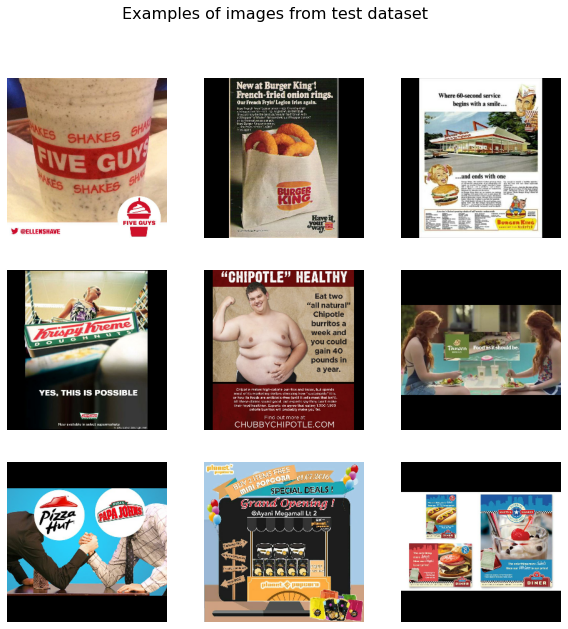

In [36]:
n_samples = 9
fig = plt.figure(figsize=(10, 10))
fig.suptitle("Examples of images from test dataset", fontsize=16)
for i, (img, label) in enumerate((test_ds.unbatch().take(n_samples).as_numpy_iterator())):
  # print(image_fp, label)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(img)
#  plt.title(label)
  plt.axis("off")

## Define the model

### VGG16

In [74]:
from keras.layers.pooling import GlobalAveragePooling2D
base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights='imagenet',
                                    input_shape=(256,256,3))
base_model.trainable = False

model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(128, activation=tf.nn.relu),
                            tf.keras.layers.Dense(n_classes, activation='softmax')
])


### Efficientnet B1

In [75]:
base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False,
                                                              weights='imagenet',
                                                              input_shape=(256,256,3))
base_model.trainable = False

model = tf.keras.Sequential([base_model,
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.2),
                            tf.keras.layers.Dense(n_classes, activation='softmax')
])


### Compile Model

In [76]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.TopKCategoricalAccuracy()])

In [40]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001,verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(
                                              monitor='val_loss',
                                              min_delta=0,
                                              patience=10,
                                              verbose=0,
                                              mode='auto',
                                              restore_best_weights=True)

In [77]:
his = model.fit(train_ds,
                epochs=30,
                verbose=1,
                callbacks=[reduce_lr,early_stop],
                validation_data=valid_ds,
                initial_epoch=0,
                steps_per_epoch=len(train_ds))
# Save the trained model
save_dir = '/content/drive/MyDrive/Colab Notebooks/apply_ml/eff_aug'
model.save(os.path.join(save_dir,'eff_aug.h5'))

Epoch 1/30
214/214 [==============================] - 130s 439ms/step - loss: 2.0815 - categorical_accuracy: 0.4248 - top_k_categorical_accuracy: 0.7390 - val_loss: 2.2406 - val_categorical_accuracy: 0.3377 - val_top_k_categorical_accuracy: 0.6933 - lr: 0.0010
Epoch 2/30
214/214 [==============================] - 104s 378ms/step - loss: 1.4388 - categorical_accuracy: 0.5673 - top_k_categorical_accuracy: 0.8742 - val_loss: 2.3938 - val_categorical_accuracy: 0.3380 - val_top_k_categorical_accuracy: 0.7027 - lr: 0.0010
Epoch 3/30
214/214 [==============================] - 103s 375ms/step - loss: 1.2295 - categorical_accuracy: 0.6171 - top_k_categorical_accuracy: 0.9112 - val_loss: 2.4559 - val_categorical_accuracy: 0.3442 - val_top_k_categorical_accuracy: 0.7062 - lr: 0.0010
Epoch 4/30
214/214 [==============================] - 103s 376ms/step - loss: 1.1067 - categorical_accuracy: 0.6598 - top_k_categorical_accuracy: 0.9275 - val_loss: 2.5418 - val_categorical_accuracy: 0.3486 - val_top_

### Plot training curve

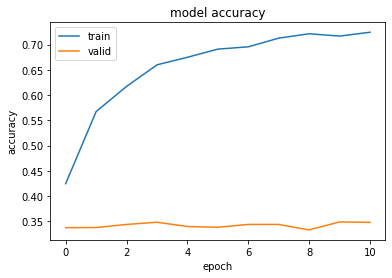

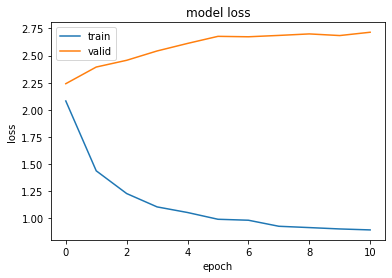

In [81]:
plt.plot(his.history['categorical_accuracy'])
plt.plot(his.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Evaluation

In [64]:
import json
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, top_k_accuracy_score, ConfusionMatrixDisplay

def evaluate(y_true,y_pred_prob):
  fig, ax = plt.subplots(figsize=(15,15))
  ax.set_title('Confusion Matrix')
  cm_plot = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize = 'true',ax=ax)
  report = classification_report(y_true,
                               y_pred, 
                               target_names = list(class_index.values()), 
                               output_dict=True)
  top_k_acc = top_k_accuracy_score(y_true,
                                  y_pred_prob,
                                  k=5)
  acc = accuracy_score(y_true,y_pred)
  return cm_plot, report, top_k_acc, acc


# Evaluate VGG16 WITHOUT image augmentation

67/67 [==============================] - 21s 312ms/step
Overall accuracy 0.41856104991797516
Overall F1-score 0.41252789369848086
Top K accuracy:  0.7478322006093274
Accuracy:  0.41856104991797516


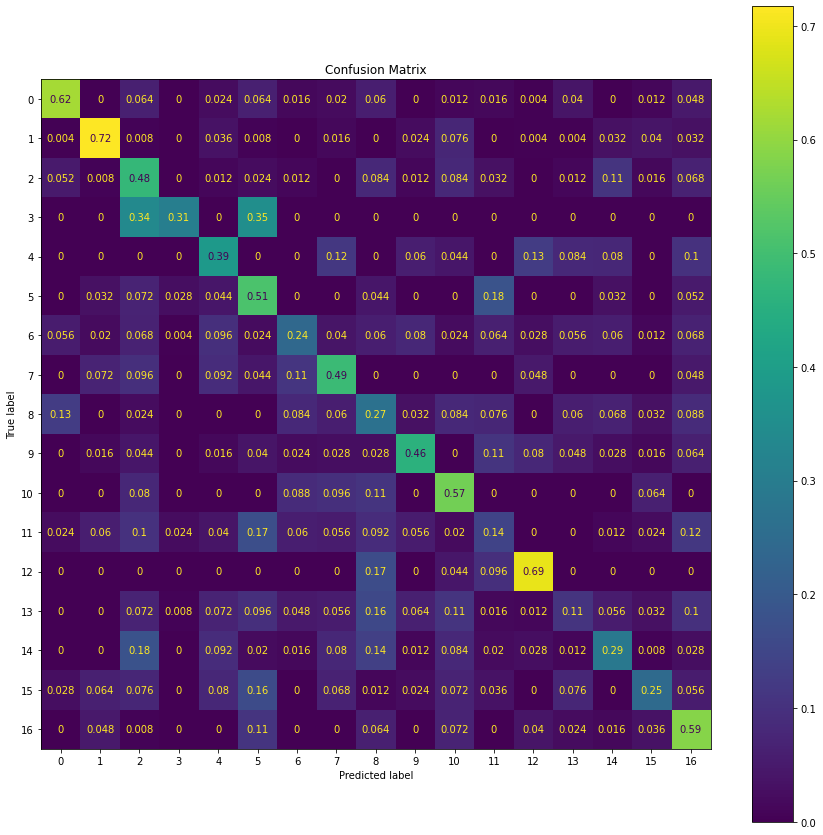

In [66]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/apply_ml/vgg16_notune/'
model = tf.keras.models.load_model(os.path.join(save_dir,'vgg16.h5'))

y_pred_prob = model.predict(test_ds,verbose = 1)
y_true = test_df.iloc[:,5:].values
y_true = y_true.argmax(-1)
y_pred = y_pred_prob.argmax(-1)

# calculates metrics
cm_plot, report, top_k_acc, acc = evaluate(y_true,y_pred_prob)

# save metrics
with open(os.path.join(save_dir,'classification_report.json'),'w') as f:
  json.dump(report,f)

metrics_dict = {'top_k_acc':top_k_acc, 'accuracy':acc}
with open(os.path.join(save_dir,'metrics.json'),'w') as f:
  json.dump(metrics_dict,f)

# Display metrics and confusion matrix
print('Overall accuracy',report['accuracy'])
print('Overall F1-score',report['weighted avg']['f1-score'])
print("Top K accuracy: ",top_k_acc)
print("Accuracy: ", acc)

cm_plot.figure_.savefig(os.path.join(save_dir,'conf_mat.png'),dpi=200)

# Evaluate VGG16 WITH image augmentation

67/67 [==============================] - 22s 310ms/step
Overall accuracy 0.28404030935083197
Overall F1-score 0.27228913184798614
Top K accuracy:  0.673072416217483
Accuracy:  0.28404030935083197


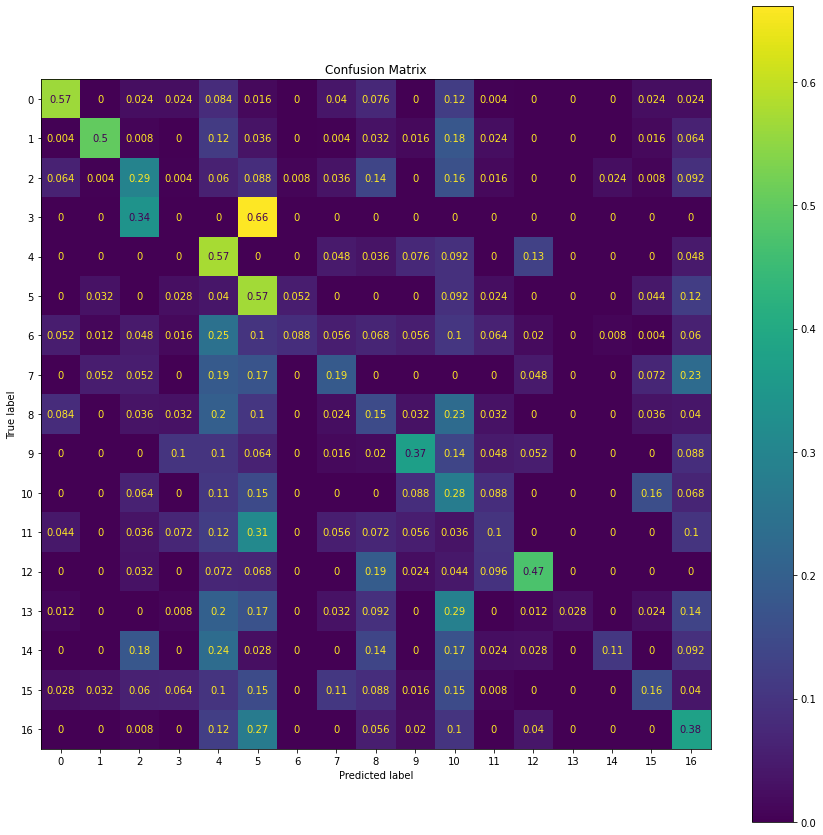

In [67]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/apply_ml/vgg_aug/'
model = tf.keras.models.load_model(os.path.join(save_dir,'vgg_aug.h5'))

y_pred_prob = model.predict(test_ds,verbose = 1)
y_true = test_df.iloc[:,5:].values
y_true = y_true.argmax(-1)
y_pred = y_pred_prob.argmax(-1)

# calculates metrics
cm_plot, report, top_k_acc, acc = evaluate(y_true,y_pred_prob)

# save metrics
with open(os.path.join(save_dir,'classification_report.json'),'w') as f:
  json.dump(report,f)

metrics_dict = {'top_k_acc':top_k_acc, 'accuracy':acc}
with open(os.path.join(save_dir,'metrics.json'),'w') as f:
  json.dump(metrics_dict,f)

# Display metrics and confusion matrix
print('Overall accuracy',report['accuracy'])
print('Overall F1-score',report['weighted avg']['f1-score'])
print("Top K accuracy: ",top_k_acc)
print("Accuracy: ", acc)

cm_plot.figure_.savefig(os.path.join(save_dir,'conf_mat.png'),dpi=200)

# Evaluate Efficientnet B1 WITHOUT image augmentation

67/67 [==============================] - 16s 219ms/step
Overall accuracy 0.42418561049917974
Overall F1-score 0.4214376815290901
Top K accuracy:  0.7384579329739864
Accuracy:  0.42418561049917974


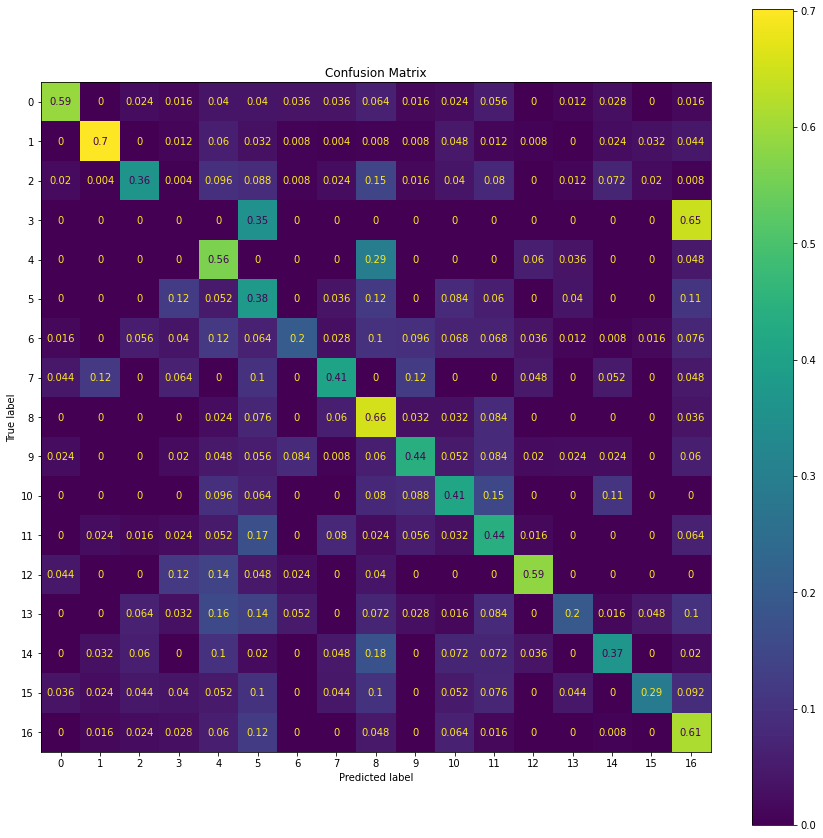

In [72]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/apply_ml/effnet_notune/'
model = tf.keras.models.load_model(os.path.join(save_dir,'effnet_notune.h5'))

y_pred_prob = model.predict(test_ds,verbose = 1)
y_true = test_df.iloc[:,5:].values
y_true = y_true.argmax(-1)
y_pred = y_pred_prob.argmax(-1)

# calculates metrics
cm_plot, report, top_k_acc, acc = evaluate(y_true,y_pred_prob)

# save metrics
with open(os.path.join(save_dir,'classification_report.json'),'w') as f:
  json.dump(report,f)

metrics_dict = {'top_k_acc':top_k_acc, 'accuracy':acc}
with open(os.path.join(save_dir,'metrics.json'),'w') as f:
  json.dump(metrics_dict,f)

# Display metrics and confusion matrix
print('Overall accuracy',report['accuracy'])
print('Overall F1-score',report['weighted avg']['f1-score'])
print("Top K accuracy: ",top_k_acc)
print("Accuracy: ", acc)

cm_plot.figure_.savefig(os.path.join(save_dir,'conf_mat.png'),dpi=200)

# Evaluate Efficientnet B1 WITH image augmentation

67/67 [==============================] - 16s 216ms/step
Overall accuracy 0.374267635340989
Overall F1-score 0.3693900743946596
Top K accuracy:  0.7333020857745489
Accuracy:  0.374267635340989


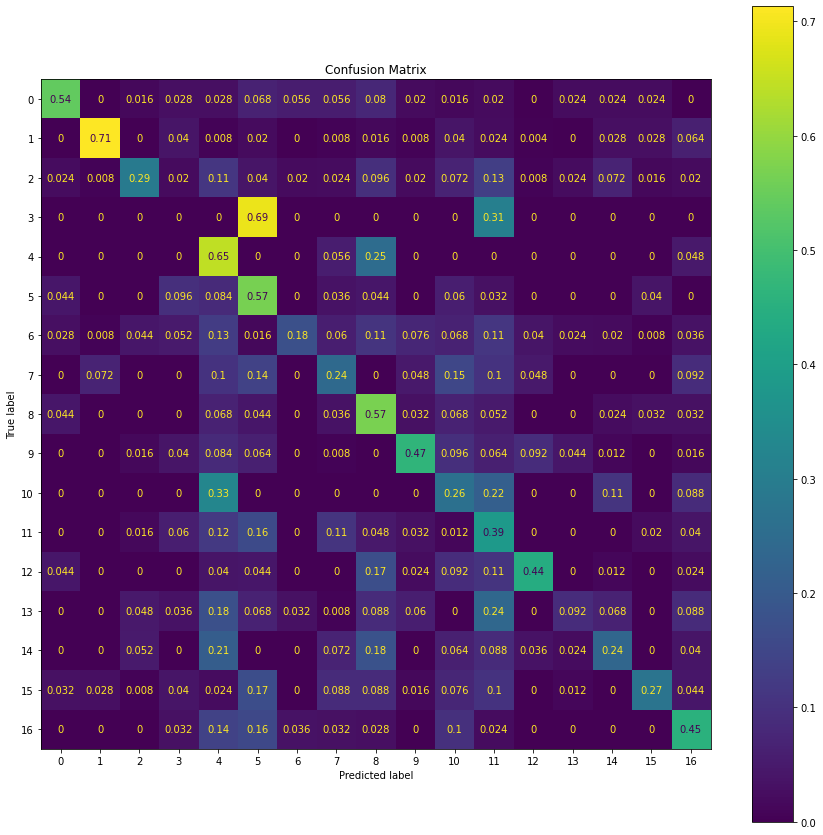

In [73]:
save_dir = '/content/drive/MyDrive/Colab Notebooks/apply_ml/eff_aug/'
model = tf.keras.models.load_model(os.path.join(save_dir,'eff_aug.h5'))

y_pred_prob = model.predict(test_ds,verbose = 1)
y_true = test_df.iloc[:,5:].values
y_true = y_true.argmax(-1)
y_pred = y_pred_prob.argmax(-1)

# calculates metrics
cm_plot, report, top_k_acc, acc = evaluate(y_true,y_pred_prob)

# save metrics
with open(os.path.join(save_dir,'classification_report.json'),'w') as f:
  json.dump(report,f)

metrics_dict = {'top_k_acc':top_k_acc, 'accuracy':acc}
with open(os.path.join(save_dir,'metrics.json'),'w') as f:
  json.dump(metrics_dict,f)

# Display metrics and confusion matrix
print('Overall accuracy',report['accuracy'])
print('Overall F1-score',report['weighted avg']['f1-score'])
print("Top K accuracy: ",top_k_acc)
print("Accuracy: ", acc)

cm_plot.figure_.savefig(os.path.join(save_dir,'conf_mat.png'),dpi=200)